In [7]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

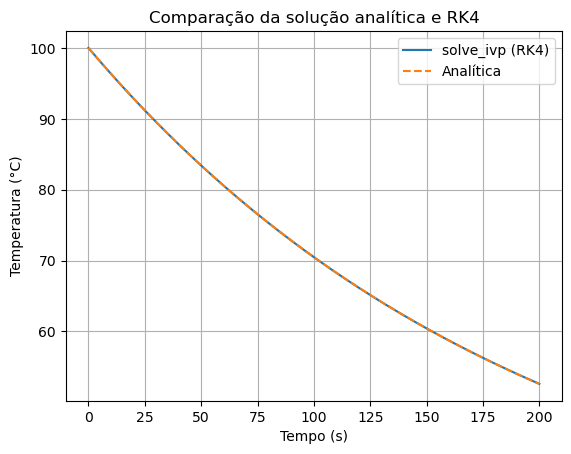

In [8]:
def dT_dt(t, T, T_amb, r):
    return r * (T_amb - T)  # Assuming ambient temperature is 20 degrees

T0 = 100  # Temperatura inicial
T_amb = 25
r = 0.005
t_span = (0, 200)
t_eval = np.linspace(*t_span, 200)

# Solução numérica
sol = solve_ivp(dT_dt, t_span, [T0], args = [T_amb, r], t_eval=t_eval)

# Solução analítica
T_analytical = T_amb + (T0 - T_amb) * np.exp(-r * t_eval)

# Plot
plt.plot(t_eval, sol.y[0], label='solve_ivp (RK4)')
plt.plot(t_eval, T_analytical, '--', label='Analítica')
plt.legend()
plt.xlabel('Tempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Comparação da solução analítica e RK4')
plt.grid()
plt.show()



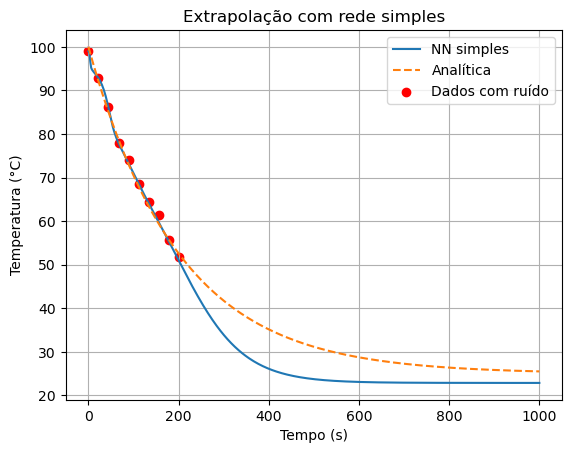

In [23]:
t_data = np.linspace(0, 200, 10)
T_data = T_amb + (T0 - T_amb) * np.exp(-r * t_data)
T_data_noisy = T_data + np.random.normal(0, 1, size=T_data.shape)

# Dados
t_train = torch.tensor(t_data, dtype=torch.float32).view(-1, 1)
T_train = torch.tensor(T_data_noisy, dtype=torch.float32).view(-1, 1)

# Rede simples
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, t):
        return self.net(t)

model = SimpleNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Treinamento
for epoch in range(10000): # com poucos daddos precisa de mais épocas
    optimizer.zero_grad()
    loss = loss_fn(model(t_train), T_train)
    loss.backward()
    optimizer.step()

# Avaliação
t_test = torch.linspace(0, 1000, 500).view(-1, 1)
T_pred = model(t_test).detach().numpy()

# Analítica para comparação
T_test_analytical = T_amb + (T0 - T_amb) * np.exp(-r * t_test.numpy().flatten())

# Plot
plt.plot(t_test.numpy(), T_pred, label='NN simples')
plt.plot(t_test.numpy(), T_test_analytical, '--', label='Analítica')
plt.scatter(t_data, T_data_noisy, color='red', label='Dados com ruído')
plt.legend()
plt.title('Extrapolação com rede simples')
plt.xlabel('Tempo (s)')
plt.ylabel('Temperatura (°C)')
plt.grid()
plt.show()

In [25]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, t):
        return self.net(t)

model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Função de perda com conhecimento de r
def pinn_loss(model, t_data, T_data, r=0.005):
    T_pred = model(t_data)
    mse_data = nn.MSELoss()(T_pred, T_data)

    # Derivada
    t_phys = torch.linspace(0, 200, 100).view(-1, 1).requires_grad_(True)
    T_phys = model(t_phys)
    dT_dt = torch.autograd.grad(T_phys, t_phys, torch.ones_like(T_phys), create_graph=True)[0]
    eq_residual = dT_dt - r * (T_amb - T_phys)
    mse_phys = torch.mean(eq_residual**2)

    return mse_data + mse_phys

# Treinamento
for epoch in range(5000):
    optimizer.zero_grad()
    loss = pinn_loss(model, t_train, T_train)
    loss.backward()
    optimizer.step()